### Finding Distribution of stock returns

#### Libraries

In [185]:
import numpy as np
import pandas as pd
import math
import random
from yahoo_finance_api2 import share
from yahoo_finance_api2.exceptions import YahooFinanceError
from datetime import date
import pylab
import matplotlib.pyplot as plt
import seaborn as sns

#### Getting stock Data
Using yahoo finance api to get the "SPY" stock data. 

SPY is the Exchange Traded Fund of S&P500, it mimics the S&P500 index

In [186]:
#Gets stock price of any S&P500 stock from start_date to end_date
def get_stock_prices(company_symbol, start_date, end_date):

    my_share = share.Share(company_symbol)
    symbol_data = pd.DataFrame()

    try:
        symbol_data = my_share.get_historical(share.PERIOD_TYPE_DAY,
                                              5,
                                              share.FREQUENCY_TYPE_MINUTE,
                                              60)
    except YahooFinanceError as e:
        print(e.message)
        sys.exit(1)
    stock_prices= pd.DataFrame(symbol_data)

    return stock_prices

#Returns the difference between opening and closing price of stock
def get_price_movements(stock_prices):
    price_change = stock_prices['open'] - stock_prices['close']
    
    return price_change


In [187]:

#df = pd.read_csv('Data.csv')
df=get_stock_prices('SPY', date(2018,1,1), date(2019,1,10))
df['Return'] = get_price_movements(df)
df.tail()

,timestamp,open,high,low,close,volume,Return
61,1576873800000,321.170013,321.26001,320.839996,320.959991,13392749,0.210022
62,1576875600000,320.860000,321.96420,319.387300,321.010000,0,-0.150000
63,1576879200000,321.050000,321.05000,320.730000,320.980000,0,0.070000
64,1576882800000,321.039900,321.28000,321.020000,321.160000,0,-0.120100
65,1576886400000,321.150000,321.30000,321.130000,321.300000,0,-0.150000


#### Expectation Maximization

For this excercise lets assume that returns of the S&P500 are a distributed as mixture of Guassians. 

##### Guassian Distribution 

Guassian/Normal is a a ubiquitous probability distribution parametarized with a mean and variance. 

With probability density function of the form: 


 ### $G(X|\mu_k, \sigma_k) = $ $\frac{1}{\sigma \sqrt {2\pi }} e^{-\frac{(x-\mu)^2}{2\sigma^2}} $
 
 By taking what is essentially the weighted average of these Guassian distributions we are able create a mixed distribution of k Guassians, represented as
 follows
 
 ### $p(X) =\sum_{k=1}^K \pi_k G(X|\mu_k, \sigma_k)$    
 
 s.t  $ \sum_{k=1}^K \pi_k = 1$
 
 The goal of the expectation maximization algorithm is to find $ \mu_k, \sigma_k, \pi_k $ that maximizes the likelihood of X. 
 The algorithm consists of two parts the Expectation step & the maximization step. In order to explain the algorithm we need to define  **$ \gamma_k = P(X|k) $**
 or the probability of X given that we know it comes from the kth cluster. 
 
 
 The algorithm goes as follows:
 
 Step 1: Intialize $ \mu_k, \sigma_k, \pi_k $ to random values. 
 
 Step 2: Compute $ \gamma_k $ for all values of k
 
 Step 3: Estimate $ \mu_k , \sigma_k, \pi_k $ using  values of $ \gamma_k $. 
 
 These estimations are done with these formula's, which are derived using the Maximum Likelihood of $P(X)$ 
 
 Formulas for restimation:
 
 #### $ \pi_k=\frac{1}{N} \sum_{n=1}^N \gamma_k(x_n) $
 ### $\mu_k=\frac{\sum_{n=1}^N \gamma_k(x_n)x_n}{\sum_{n=1}^N \gamma_k(x_n)}$
 ### $\sigma_k=\frac{\sum_{n=1}^N \gamma_k(x_n)(x_n-\mu_k)^2}{\sum{n=1}^N \gamma_k(x_n)}$
 
 where $N$ is total number of samples and $ x_n $ is the nth datapoint
 
 Step 4: Repeat until convergence.
 
 Convergence has different meaning, there can be some advanced convergence criterions but the most simplest is a fixed number of iterations. 

In [190]:
# k =number of clusters
k =3
def Initializer(k):
    #Returns a randomly initialized weights, means and standard deviation
    # intial_params contains all the intial parameters for the Guassians
    initial_params = pd.DataFrame()
    #initalizing all means to random value in df['Return']

    #initial_params['means'] = pd.Series([df['Val'].mean() for i in range(k)])
    initial_params['means'] = np.random.choice(df['Return'], k)
    #initals all stds to random values

    initial_params['std'] =np.random.random_sample(size=k)
    #intialialize all weights to be equal
    #initial_weights =[0.1,0.6,0.3]
    initial_params['weights'] = pd.Series([1/k for i in range(k)])
    
    return initial_params
initial_params = Initializer(k)
initial_params

,means,std,weights
0,0.450000,0.021139,0.333333
1,-0.340000,0.608094,0.333333
2,-0.015015,0.696879,0.333333


this is  0  iteration


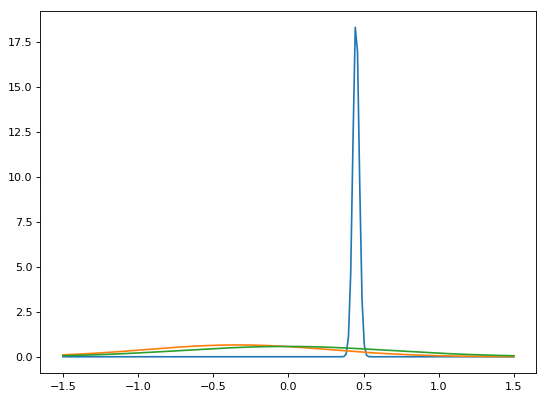

this is  50  iteration


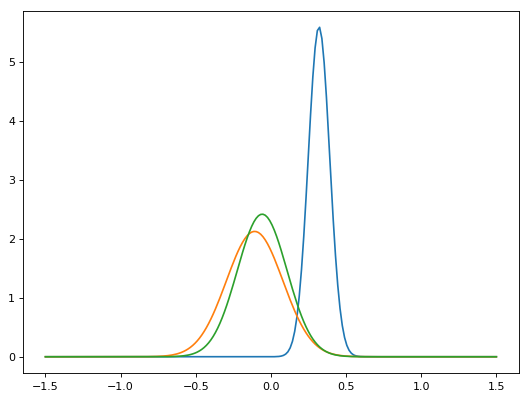

this is  100  iteration


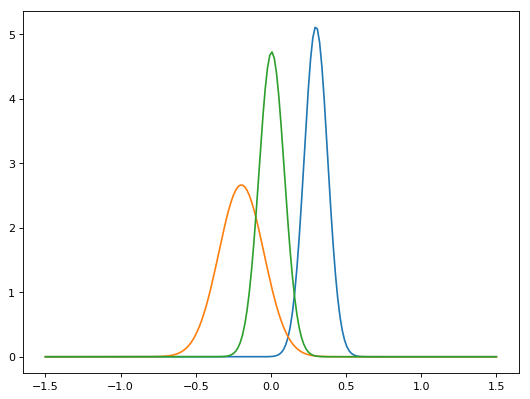

this is  150  iteration


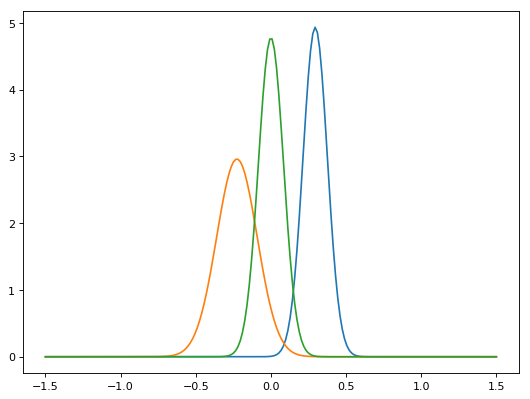

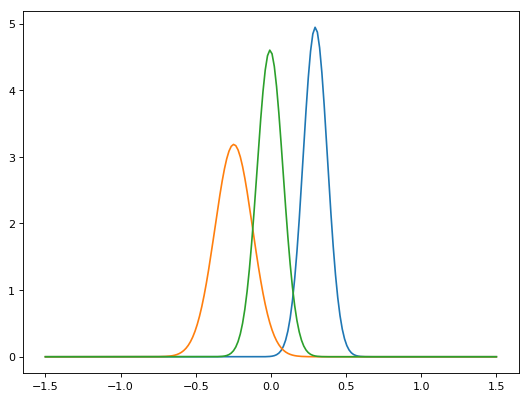

In [191]:

from scipy.stats import norm
from matplotlib.pyplot import figure

#function that plots weighted Guassians
def plot(initial_params):
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    x = np.linspace(-1.5,1.5,200)
    y = [norm.pdf(x, loc=mean, scale=sigma) for mean,sigma in zip(initial_params['means'],initial_params['std'])]   
    for Y in y:
        pylab.plot(x,Y)
    pylab.show()
def Guassian_prob(x,mean,std):
    #returns pdf of x is normally distributed
    return norm.pdf(x,mean, std)

def Expectation_Maximization(df, initial_params,k, max_iterations):
    for t in range(max_iterations):
        
        if(t%50==0):
            print("this is ",t," iteration")
            plot(initial_params)
        #Expectation_Step

        #name is just so that the dataframe has an appropriate name scheme
        name = 'Gamma_'
        #Gammas contains all probs
        Gammas = pd.DataFrame()
        temp_list =[]
        for i in range(k):
            #Iterate over number of Clusters
            for vals in df['Return']:
                #Iterate over all vals
                temp_list.append(initial_params['weights'][i]*Guassian_prob(vals,initial_params['means'][i],initial_params['std'][i]))
            #compute likelihoods and store in Gamma
            Gammas[name+str(i+1)] =pd.Series(temp_list)
            temp_list=[]

        #Normalizes all columns
        Gammas= Gammas.div(Gammas.sum(axis=1), axis=0)

        #Maximization Step



        pi_k = []
        mu_k = []
        std_k =[]
        #Sum=[]
        for columns in Gammas.columns:
            #total equals total values in dataset
            total =Gammas.count()[0]
            #Sum is the row wise sum of all probs
            Sum = Gammas[columns].sum(axis=0)
            #Using formula for pi_k
           
            pi_k.append(Sum/total)
            #multplying value and prob together
            temp = [val*prob for val,prob in zip(df['Return'],Gammas[columns])]
            #using formula of Means
            mu_k.append(sum(temp)/Sum)
        #display(mu_k)
        i =0
        #seperate loop for stds
        for columns in Gammas.columns:
            #temp has all deviations from mean squared multiplied by the probability of that event
            temp = [prob*(val-mu_k[i])**2 for val,prob in zip(df['Return'],Gammas[columns])]
            Sum = Gammas[columns].sum(axis=0)
            #display(sum(temp))
            #Formula for stds_k
            std_k.append(sum(temp)/Sum)
            i+=1

        initial_params['weights'] =pd.Series(pi_k)
        initial_params['means'] =pd.Series(mu_k)
        initial_params['std'] =pd.Series(np.sqrt(std_k))
        Gammas= pd.DataFrame()

    
        
        
    
            

        
       
        
        
    plot(initial_params)
    
    return initial_params
    
    
l = Expectation_Maximization(df,initial_params,k,200)


In [192]:
l

,means,std,weights
0,0.295199,0.080682,0.174793
1,-0.247119,0.125193,0.350000
2,-0.005945,0.086695,0.475208
